# Task Assignment Optimization Problem with Gurobi Framework

Module Name: solution.py
Obective: Task Assignment Optimization Problem Solution

Description:
This module contains the solution for the Task Assignment Optimization Problem.
The solution is divided into several sections, each responsible for a specific task:

1. Data Input: Functions to read and validate input data for the task assignment problem.
2. Optimization Model: Implementation of the optimization model using appropriate algorithms.
3. Constraints and Objectives: Definition of constraints and objective functions used in the optimization.
4. Solution Execution: Functions to execute the optimization model and obtain results.
5. Output Processing: Functions to format and output the results in a user-friendly manner.

Functions:

- s1_data_structure(employee_path, task_path): Pre-process and structure employee and task data.
- s2_construct_model(license_path): Construct the optimization model with specified parameters.
- s3_decision_variable(model, tasks, employees, company_tasks): Define decision variables for the model.
- s4_constraint(model, x, y, z, employees, company_tasks, story_points, max_workload): Set constraints for the optimization model.
- s5_objective1(model, employees, company_tasks, y, score, story_points, max_employee_workload, mu_Z_star): Minimize the idle employee.
- s6_objective2(model, employees, company_tasks, z, score, story_points, max_employee_workload, mu_Z_star): Maximize the assessment score.
- s7_objective3(model, employees, company_tasks, score, story_points, max_employee_workload, max_workload, mu_Z_star): Balance the workload for each employee.
- s8_MOO(model, employees, company_tasks, score, story_points, max_employee_workload, mu_Z_1, mu_Z_2, mu_Z_3, mu_Z_star, assessment_score_1, assessment_score_2, assessment_score_3): Multi-Objective Optimization using Goal Programming.

Classes:

- GapCallback: A callback class to report optimization progress and gap.

Usage:
Import the module in requirement file and yippy file to process the assessment.
The solution can be executed by running the main() function, which orchestrates
the entire workflow from data input to output processing.

Example:
from task_assignment_optimization import main

    if __name__ == "__main__":
        main()

Author:
TK Bunga Matahari Team
N. Muafi, I.G.P. Wisnu N., F. Zaid N., Fauzi I.S., Joseph C.L., S. Alisya

Last Modified:
June 2024

---

# 0. The Obligatory Part

### Import The Important Library


In [1]:
# Import library
import os
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from typing import Dict, List, Tuple, Any
from gurobipy import GRB, Model, quicksum
from yippy import CompetencyAssessment, WeightedEuclideanDistance

### User Arguments


In [2]:
# Load environment variables from .env file
load_dotenv()

True

In [3]:
# Convert string to boolean
def str_to_bool(value: str) -> bool:
    """
    Convert a string representation of truth to a boolean value.

    This function takes a string and converts it to a boolean. The conversion
    is case-insensitive and considers the strings "true", "1", and "yes" as
    True, and all other strings as False.

    Args:
        value (str): The string to be converted to a boolean. Expected values are
                     case-insensitive "true", "1", "yes" for True, and anything else for False.

    Returns:
        bool: The boolean value corresponding to the string representation.
              Returns True for "true", "1", "yes" (case-insensitive), and False otherwise.

    Examples:
        >>> str_to_bool("true")
        True
        >>> str_to_bool("False")
        False
        >>> str_to_bool("YES")
        True
        >>> str_to_bool("no")
        False
    """
    return value.lower() in ("true", "1", "yes")

In [4]:
# Get License Information from Environment Variables
wls_access_id = os.getenv("WLSACCESSID")
wls_secret = os.getenv("WLSSECRET")
license_id = os.getenv("LICENSEID")

if wls_access_id is None or wls_secret is None or license_id is None:
    license_params = {}
else:
    license_params = {
        "WLSACCESSID": wls_access_id,
        "WLSSECRET": wls_secret,
        "LICENSEID": int(license_id),
    }

# Optimization Parameters from Environment Variables
presolve = int(os.getenv("PRESOLVE", 2))
MIPFocus = int(os.getenv("MIPFOCUS", 1))
MIPGap = float(os.getenv("MIPGAP", 0.01))
heuristics = float(os.getenv("HEURISTICS", 0.8))
threads = int(os.getenv("THREADS", 2))
MIPGap_moo = float(os.getenv("MIPGAP_MOO", 0.05))

# Objective Weights from Environment Variables
weight_obj1 = float(os.getenv("WEIGHT_OBJ1", 0.03))
weight_obj2 = float(os.getenv("WEIGHT_OBJ2", 0.9))
weight_obj3 = float(os.getenv("WEIGHT_OBJ3", 0.07))

# Methodology from Environment Variables
overqualification = str_to_bool(os.getenv("OVERQUALIFICATION", "True"))

# File Paths from Environment Variables
employee_path = os.getenv("EMPLOYEE_PATH", "./data/employees_data.csv")
task_path = os.getenv("TASK_PATH", "./data/tasks_data.csv")

# Maximum Workload from Environment Variables
max_employee_workload = int(os.getenv("MAX_EMPLOYEE_WORKLOAD", 20))

# 1. Set Up The Data Structure

Sets up the data structure by processing employee, task data, and calculate skills metric score.

**Args:**

- employee_path (str): The path to the employee data CSV file.
- task_path (str): The path to the task data CSV file.
- overqualification (bool): Flag to choice skills metric methodhology.

**Returns:**

Tuple: Contains employees, tasks, story_points, company_tasks, score, and info.

**Dataset Structure:**

The following are examples of how the employee and task datasets must be created:

**Employee Data:**

```python
>>> import pandas as pd
>>> employee_skills_df = pd.DataFrame({
...     'math': [5, 3, 4, 4, 2],
...     'python': [5, 4, 4, 4, 3],
...     'sql': [3, 5, 4, 5, 2],
...     'cloud': [2, 4, 3, 5, 4],
...     'database': [2, 3, 4, 5, 4],
...     'optimization': [5, 5, 3, 4, 1]
... }, index=['Talent 1', 'Talent 2', 'Talent 3', 'Talent 4', 'Talent 5'])
>>> employee_skills_df
		math  python  sql  cloud  database  optimization
Talent 1     5       5    3      2         2             5
Talent 2     3       4    5      4         3             5
Talent 3     4       4    4      3         4             3
Talent 4     4       4    5      5         5             4
Talent 5     2       3    2      4         4             1
```

**Task Data:**

```python
>>> task_df = pd.DataFrame({
...     'project_id': ['P2', 'P2', 'P3', 'P3', 'P2', 'P2', 'P3', 'P1', 'P1', 'P3'],
...     'story_points': [1, 2, 3, 4, 0, 0, 0, 5, 2, 5],
...     'math': [0, 3, 5, 4, 0, 4, 3, 3, 0, 5],
...     'python': [5, 3, 4, 3, 2, 1, 3, 4, 3, 5],
...     'sql': [3, 5, 4, 3, 1, 5, 4, 5, 2, 5],
...     'cloud': [4, 4, 5, 3, 0, 5, 4, 5, 0, 5],
...     'database': [4, 3, 5, 3, 1, 0, 3, 5, 2, 0],
...     'optimization': [0, 1, 5, 0, 5, 0, 4, 2, 2, 5]
... }, index=['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10'])
>>> task_df
		project_id  story_points  math  python  sql  cloud  database  optimization
T1              P2             1     0       5    3      4         4             0
T2              P2             2     3       3    5      4         3             1
T3              P3             3     5       4    4      5         5             5
T4              P3             4     4       3    3      3         3             0
T5              P2             0     0       2    1      0         1             5
T6              P2             0     4       1    5      5         0             0
T7              P3             0     3       3    4      4         3             4
T8              P1             5     3       4    5      5         5             2
T9              P1             2     0       3    2      0         2             2
T10             P3             5     5       5    5      5         0             5
```

**Example:**

```python
employees, tasks, story_points, company_tasks, score, info = s1_data_structure('employees.csv', 'tasks.csv')
```

## 1.1. Pre-Processing: Employee Data


In [5]:
# Read data of Employee Data
employee_skills_df = pd.read_csv(employee_path, index_col="employee_id")
employee_skills_df.drop(columns=["No", "Role"], inplace=True, errors="ignore")

employees = employee_skills_df.index.tolist()
skills_name = employee_skills_df.columns[1:].tolist()

employee_skills_df

,math,python,sql,cloud,database,optimization
employee_id,,,,,,
Talent 1,5,5,3,2,2,5
Talent 2,2,5,4,3,3,1
Talent 3,4,4,5,3,4,3
Talent 4,3,4,5,5,4,2
Talent 5,2,3,2,4,5,1


## 1.2. Pre-Processing: Task Data


In [6]:
# Read data of Task Data
task_df = pd.read_csv(task_path, index_col="task_id")

tasks = task_df.index.tolist()
company_names = list(set(task_df["project_id"]))
story_points = task_df["story_points"].to_dict()

task_df

,project_id,story_points,math,python,sql,cloud,database,optimization
task_id,,,,,,,,
T1,P2,1,0,5,3,4,4,0
T2,P1,2,3,5,4,5,3,1
T3,P2,3,5,4,2,0,0,5
T4,P3,5,2,4,0,3,0,4
T5,P3,1,0,3,5,1,5,0
T6,P1,1,0,1,4,5,5,0
T7,P3,2,4,4,1,1,2,3
T8,P1,3,1,0,5,5,3,0
T9,P2,1,3,4,3,0,0,2


## 1.3. Group the task data by company/project


In [7]:
# convert to dictionary each company and its task
company_tasks = {}

for company in company_names:
	company_tasks[company] = task_df[
		task_df["project_id"] == company
	].index.tolist()

# sort the company tasks from C1 to C5
company_tasks = dict(sorted(company_tasks.items()))

company_tasks_df = pd.DataFrame.from_dict(company_tasks, orient="index")
company_tasks_df

,0,1,2,3
P1,T2,T6,T8,T10
P2,T1,T3,T9,None
P3,T4,T5,T7,None


## 1.4. Pre-Processing: Skill Metric Score Calculation

First, create RCD-ACD Dataframe that we get from Task Dataframe for RCD and from Employee Dataframe for ACD.

### 1.4.1 Required Competence Data

In [8]:
rcd_df = task_df.drop(columns=["project_id", "story_points"])
rcd_df = rcd_df.fillna(0)
rcd_df

,math,python,sql,cloud,database,optimization
task_id,,,,,,
T1,0,5,3,4,4,0
T2,3,5,4,5,3,1
T3,5,4,2,0,0,5
T4,2,4,0,3,0,4
T5,0,3,5,1,5,0
T6,0,1,4,5,5,0
T7,4,4,1,1,2,3
T8,1,0,5,5,3,0
T9,3,4,3,0,0,2


### 1.4.2 Acquired Competence Data


In [9]:
# create a copy of the original DataFrame
acd_df = employee_skills_df.copy()
acd_df = acd_df.fillna(0)
acd_df

,math,python,sql,cloud,database,optimization
employee_id,,,,,,
Talent 1,5,5,3,2,2,5
Talent 2,2,5,4,3,3,1
Talent 3,4,4,5,3,4,3
Talent 4,3,4,5,5,4,2
Talent 5,2,3,2,4,5,1


### 1.4.3 Calculate Skills Metric

In [10]:
if overqualification:	
	# Calculate with Competency Assessment
	ca = CompetencyAssessment(rcd_df, acd_df)
	score, info = ca.fit()
else:
	# Calculate with Weighted Euclidean Distance
    wed = WeightedEuclideanDistance(acd_df, rcd_df)
    score, info = wed.fit()

In [11]:
score

{'Talent 1': {'T10': 1.0,
  'T3': 0.4641016151377546,
  'T4': 0.2910493488228408,
  'T7': 0.28989794855663564,
  'T9': 0.28544261659540726,
  'T1': 0.2612038749637414,
  'T5': 0.20168959288722538,
  'T2': 0.18933139574356017,
  'T8': 0.1852891992413258,
  'T6': 0.16855212267069633},
 'Talent 2': {'T1': 0.3797958971132712,
  'T9': 0.353889367864523,
  'T2': 0.3090169943749474,
  'T8': 0.2958163163244893,
  'T5': 0.25,
  'T4': 0.24336073281110826,
  'T6': 0.21498516621900873,
  'T7': 0.20557658844381702,
  'T10': 0.16666666666666666,
  'T3': 0.15974667297574377},
 'Talent 3': {'T4': 0.36602540378443865,
  'T9': 0.353889367864523,
  'T5': 0.3430703308172536,
  'T1': 0.3333333333333333,
  'T10': 0.28989794855663564,
  'T8': 0.25805245234583163,
  'T3': 0.25428627101618895,
  'T2': 0.25,
  'T6': 0.24727258247841533,
  'T7': 0.24660605559646726},
 'Talent 4': {'T9': 0.4142135623730951,
  'T8': 0.3797958971132712,
  'T2': 0.36602540378443865,
  'T1': 0.3430703308172536,
  'T6': 0.303497327439

# 2. Construct the Model

## 2.1 Get The License of Gurobi


In [12]:
# get the license file
def read_license_file(filepath):
    params = {}
    with open(filepath, "r") as file:
        for line in file:
            if line.startswith("WLSACCESSID"):
                params["WLSACCESSID"] = line.split("=")[1].strip()
            elif line.startswith("WLSSECRET"):
                params["WLSSECRET"] = line.split("=")[1].strip()
            elif line.startswith("LICENSEID"):
                params["LICENSEID"] = int(line.split("=")[1].strip())
    return params

## 2.2. Instance the Model


In [13]:
# Create an environment with WLS license
env = gp.Env(params=license_params) if license_params else None

# Create the model within the Gurobi environment
model = Model(name="task_assignment", env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2521640
Academic license 2521640 - for non-commercial use only - registered to na___@mail.ugm.ac.id


## 2.3. Set Tune Parameters


In [14]:
# Set Gurobi parameters to improve performance
model.setParam("Presolve", presolve)  # Aggressive presolve
model.setParam("MIPFocus", MIPFocus)  # Focus on improving the best bound
model.setParam("MIPGap", MIPGap)  # 1% optimality gap
model.setParam("Heuristics", heuristics)  # Increase heuristics effort
model.setParam("Threads", threads)  # Use 8 threads, adjust based on your CPU

Set parameter Presolve to value 2
Set parameter MIPFocus to value 1
Set parameter MIPGap to value 0.01
Set parameter Heuristics to value 0.8
Set parameter Threads to value 2


## 2.4. Create a Callback

Create a Callback for get the gap information


In [15]:
class GapCallback:
    """
    A callback class for monitoring and reporting the optimization gap during the Mixed Integer Programming (MIP) solving process.

    Attributes:
        reported_gaps (set): A set to keep track of the reported gaps to avoid duplicate notifications.
    """

    def __init__(self) -> None:
        """
        Initializes the GapCallback instance with an empty set for reported gaps.

        Example:
            callback = GapCallback()
        """
        self.reported_gaps = set()

    def __call__(self, model: Model, where: int) -> None:
        """
        The callback function that gets called during the MIP solving process. It monitors the optimization gap and sends notifications when certain conditions are met.

        Args:
            model (gurobipy.Model): The optimization model being solved.
            where (int): An integer code indicating the point in the solving process when the callback is called.

        Example:
            model = Model()
            callback = GapCallback()
            model.optimize(callback)
        """
        if where == GRB.Callback.MIP:
            nodecount = model.cbGet(GRB.Callback.MIP_NODCNT)
            if (
                nodecount % 100 == 0
            ):  # Adjust the frequency of the callback call if needed
                obj_best = model.cbGet(GRB.Callback.MIP_OBJBST)
                obj_bound = model.cbGet(GRB.Callback.MIP_OBJBND)
                if obj_best < GRB.INFINITY and obj_bound > -GRB.INFINITY:
                    gap = abs((obj_bound - obj_best) / obj_best) * 100
                    percentage_gap = gap

                    # Report gap for multiples of 5
                    if percentage_gap > 10 and int(percentage_gap) % 5 == 0:
                        if int(percentage_gap) not in self.reported_gaps:
                            print(f"Model reached {int(percentage_gap)}% gap.")
                            self.reported_gaps.add(int(percentage_gap))

                    # Report gap for each integer when gap <= 10
                    elif percentage_gap <= 10:
                        if int(percentage_gap) not in self.reported_gaps:
                            print(f"Model reached {percentage_gap}% gap.")
                            self.reported_gaps.add(int(percentage_gap))

# 3. Build the Decision Variable

We have 3 sets:

$$
\text{sets} = \begin{cases}
I &: \text{set of tasks} \\
J &: \text{set of employees} \\
K &: \text{set of projects}
\end{cases}
$$

Next, we define parameters, scalars, and data structures. Let:

$$
\begin{align*}
i & = \text{task } i \\
j & = \text{employee } j \\
k & = \text{project } k \\
s_i & = \text{story points of task } i \\
e_{ij} & = \text{similarity skills of employee } j \text{ for task } i \\
\mu_{Z_n} & = \text{Objective} n {Function}\\
\mu_{Z_n^{\ast}} & = \text{Goal of each Objective Function} \\
d_{n}^+ & = \text{Overachievement of each objective} \\
d_{n}^- & = \text{Underachievement of each objective} \\
W & = \text{Weight priority of each objective}
\end{align*}
$$

**Decision Variables:**

$$
\begin{align*}
x_{ijk} & = \text{Binary variable indicate the employee } j \text{ is assigned to task } i \text{ in project } k \\
y_{jk} & = \text{Binary variable indicate the employee } j \text{ is assigned to project } k \\
z_{ij} & = \text{Binary variable indicate the task } i \text{ is assigned to employee } j \\
max\_workload & = \text{Integer variable indicate the maximum workload that can be assigned}
\end{align*}
$$


In [16]:
# Create decision variables for x and y

# Decision variable x to represent employee j is assigned to task i in project k
x = {}
for k, task in company_tasks.items():
    for i in task:
        for j in employees:
            x[(i, j, k)] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}_{k}")

# Decision variable y to represent employee j is assigned to project k
y = {}
for j in employees:
    for k in company_tasks.keys():
        y[(j, k)] = model.addVar(vtype=GRB.BINARY, name=f"y_{j}_{k}")

# Decision variable z to represent task i is assigned to employee j
z = {}
for i in tasks:
    for j in employees:
        z[(i, j)] = model.addVar(vtype=GRB.BINARY, name=f"z_{i}_{j}")

# Decision variable for max workload that can be assigned
max_workload = model.addVar(
    vtype=GRB.INTEGER, lb=0, ub=max_employee_workload, name="max_workload"
)

# Integrate new variables
model.update()

In [17]:
# print he decision variables
print(x)
print(y)

{('T2', 'Talent 1', 'P1'): <gurobi.Var x_T2_Talent 1_P1>, ('T2', 'Talent 2', 'P1'): <gurobi.Var x_T2_Talent 2_P1>, ('T2', 'Talent 3', 'P1'): <gurobi.Var x_T2_Talent 3_P1>, ('T2', 'Talent 4', 'P1'): <gurobi.Var x_T2_Talent 4_P1>, ('T2', 'Talent 5', 'P1'): <gurobi.Var x_T2_Talent 5_P1>, ('T6', 'Talent 1', 'P1'): <gurobi.Var x_T6_Talent 1_P1>, ('T6', 'Talent 2', 'P1'): <gurobi.Var x_T6_Talent 2_P1>, ('T6', 'Talent 3', 'P1'): <gurobi.Var x_T6_Talent 3_P1>, ('T6', 'Talent 4', 'P1'): <gurobi.Var x_T6_Talent 4_P1>, ('T6', 'Talent 5', 'P1'): <gurobi.Var x_T6_Talent 5_P1>, ('T8', 'Talent 1', 'P1'): <gurobi.Var x_T8_Talent 1_P1>, ('T8', 'Talent 2', 'P1'): <gurobi.Var x_T8_Talent 2_P1>, ('T8', 'Talent 3', 'P1'): <gurobi.Var x_T8_Talent 3_P1>, ('T8', 'Talent 4', 'P1'): <gurobi.Var x_T8_Talent 4_P1>, ('T8', 'Talent 5', 'P1'): <gurobi.Var x_T8_Talent 5_P1>, ('T10', 'Talent 1', 'P1'): <gurobi.Var x_T10_Talent 1_P1>, ('T10', 'Talent 2', 'P1'): <gurobi.Var x_T10_Talent 2_P1>, ('T10', 'Talent 3', 'P1'):

# 4. Subject to the Constraint

## 4.1. Constraint 1: Each task is assigned to one employee

$$
\sum _{j\in J}\:x_{ijk}\:=\:1 \quad \forall i \in I_k, \: k \in K
$$


In [18]:
# constraint 1: each task assigned to one talent
for k, task in company_tasks.items():
    for i in task:
        model.addConstr(quicksum(x[(i, j, k)] for j in employees) == 1)

## 4.2. Constraint 2: Each employee works for one company at a time

Pre-Processing for Constraint 2:

$$
\sum _{i\in I_k}x_{ijk} > 0 \: \rightarrow \: y_{jk}=1 \quad \forall j\in J, \: k\in K\:
$$


In [19]:
# pre-processing constraint 2
for j in employees:
    for k, task in company_tasks.items():
        # Use quicksum to sum up x[i][j][k] for all i
        temp_sum = quicksum(x[i, j, k] for i in task)

        # Add a constraint to the model: y[j][k] is 1 if the sum of x[i][j][k] for all i is > 0, and 0 otherwise
        model.addGenConstrIndicator(y[j, k], True, temp_sum, GRB.GREATER_EQUAL, 1)
        model.addGenConstrIndicator(y[j, k], False, temp_sum, GRB.LESS_EQUAL, 0)

Main Constraint:

$$
\sum _{k\in K}y_{jk}\le 1 \quad \forall j\in J
$$


In [20]:
# create constraint 2: each employee can only work on one task
for j in employees:
    # The sum of y[j][k] for all companies (k) should be <= 1
    model.addConstr(quicksum(y[(j, k)] for k in company_tasks.keys()) <= 1)

## 4.3. Constraint 3: Employee workload doesn't exceed the capacity

Balance the workload, so the capacity of each employee is the sum of their story points, which is story points20.

$$
\sum _{i \in I_k} s_i \cdot x_{ijk} \le max\_employee\_workload \quad \forall j\in J, \: k\in K
$$


In [21]:
# constraint 3: employee workload should not exceed the maximum workload
for j in employees:
    for k, tasks in company_tasks.items():
        model.addConstr(
            quicksum(story_points[i] * x[(i, j, k)] for i in tasks)
            <= max_employee_workload
        )

## 4.4. Constraint 4: To achieve the balance workload, set the maximum workload to be greater than or equal to the workload for each employee

$$
\text{max\_workload} \ge \sum_{i \in I_k} \sum_{k \in K} s_i\cdot x_{ijk}, \quad \forall j\in J\:\:
$$


In [22]:
# constraint 4: max_workload is greater than or equal to the workload of each employee
for j in employees:
    model.addConstr(
        max_workload
        >= quicksum(
            story_points[i] * x[i, j, k]
            for k, tasks in company_tasks.items()
            for i in tasks
        )
    )

## 4.5. Constraint 5: Implication Constraint for Minimizing Iterations: Ensure Valid Task Assignment and Employee Availability Across Companies

$$
x_{ijk}=1\:\rightarrow \:y_{jk}=1\:\rightarrow \:z_{ij}=1  \quad \forall i \in I_k, \: j \in J, \: k \in K
$$


In [23]:
# pre-processing for contraint 5 to ensure that the value of z is <= 1
for i in tasks:
    model.addConstr(quicksum(z[(i, j)] for j in employees) <= 1)

In [24]:
# constraint 5: if employee j is assigned to project k, then z[i, j] and x[i, j, k] is 1
for k, tasks in company_tasks.items():
    for i in tasks:
        for j in employees:
            model.addGenConstrIndicator(x[i, j, k], True, z[i, j], GRB.EQUAL, 1)
            model.addGenConstrIndicator(z[i, j], True, y[j, k], GRB.EQUAL, 1)

# 5. Single Objective Approach: 1) Minimize The Idle Employee

## 5.1. Set The Objective Model

$$
\mu _{Z_1} = min.\:\sum _{j\in \:J}\:\left(1\:-\:\sum _{k\in \:K}\:y_{jk}\right) \quad \tag{1}
$$


In [25]:
# objective 1
idle = []

for j in employees:
    idle.append(1 - quicksum(y[j, k] for k in company_tasks.keys()))

mu_Z_1 = quicksum(idle)

# single objective 1
model.setObjective(mu_Z_1, GRB.MINIMIZE)

## 5.2. Solve The Model of Objective $(1)$


In [26]:
# solve the model
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 2 threads

Academic license 2521640 - for non-commercial use only - registered to na___@mail.ugm.ac.id
Optimize a model with 38 rows, 116 columns and 185 nonzeros
Model fingerprint: 0x4ed118a1
Model has 130 general constraints
Variable types: 0 continuous, 116 integer (115 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
  GenCon rhs range [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 47 rows and 0 columns
Presolve removed 0 rows and 51 columns
Presolve time: 0.00s
Presolved: 85 rows, 65 columns, 295 nonzeros
Variable types: 0 continuous, 65 integer (65 binary)
Found heuristic solution: objective 0.0000000
Root relaxation presolve

#### Generic Function


In [27]:
mu_Z_star = {i: 0.00 for i in range(1, 4)}


# Extracting and printing the results
def get_employee_tasks(
    j, company_tasks, model, score, story_points, max_employee_workload
):
    task = []
    sim = []
    comp = []
    sp = 0

    for k, tasks in company_tasks.items():
        for i in tasks:
            if x[i, j, k].X == 1:
                print(f"Task {i} assigned to Employee {j}")
                print(f"Company\t\t\t: {k}")
                print(f"Story Points\t\t: {story_points[i]}")
                print(f"Metrics score\t: {score[j][i]:.10f}\n")

                task.append(i)
                sim.append(score[j][i])
                comp.append(k)
                sp += story_points[i]

    wasted_sp = max_employee_workload - sp if sp > 0 else 0
    return comp, task, sp, wasted_sp, sim

### 5.2.1 Print The Solver Results


In [28]:
# Check and process the solution
if model.status == GRB.OPTIMAL:
    print("Solution Found!")
    print(f"Obj. Value 1 i.e. Total Idle Employees: {model.ObjVal}\n")
    mu_Z_star[1] = model.ObjVal

    x_hat_1 = {}
    for j in employees:
        result = get_employee_tasks(
            j, company_tasks, model, score, story_points, max_employee_workload
        )
        if len(result[1]) > 0:
            x_hat_1[j] = result
else:
    print("No Solution Found!")
    x_hat_1 = {}

Solution Found!
Obj. Value 1 i.e. Total Idle Employees: 0.0

Task T1 assigned to Employee Talent 1
Company			: P2
Story Points		: 1
Metrics score	: 0.2612038750

Task T3 assigned to Employee Talent 1
Company			: P2
Story Points		: 3
Metrics score	: 0.4641016151

Task T9 assigned to Employee Talent 1
Company			: P2
Story Points		: 1
Metrics score	: 0.2854426166

Task T2 assigned to Employee Talent 2
Company			: P1
Story Points		: 2
Metrics score	: 0.3090169944

Task T4 assigned to Employee Talent 3
Company			: P3
Story Points		: 5
Metrics score	: 0.3660254038

Task T5 assigned to Employee Talent 3
Company			: P3
Story Points		: 1
Metrics score	: 0.3430703308

Task T7 assigned to Employee Talent 3
Company			: P3
Story Points		: 2
Metrics score	: 0.2466060556

Task T10 assigned to Employee Talent 4
Company			: P1
Story Points		: 3
Metrics score	: 0.2108967221

Task T6 assigned to Employee Talent 5
Company			: P1
Story Points		: 1
Metrics score	: 0.2742918852

Task T8 assigned to Employee 

## 5.3. Show the Solver's Result


In [29]:
# Set display options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# Convert dictionary to DataFrame and set 'employee' as index
result_1 = pd.DataFrame.from_dict(
    x_hat_1,
    orient="index",
    columns=["company", "assigned_task", "sum_sp", "wasted_sp", "assessment_score"],
)
result_1.index.name = "employee"

result_1

,company,assigned_task,sum_sp,wasted_sp,assessment_score
employee,,,,,
Talent 1,"[P2, P2, P2]","[T1, T3, T9]",5,5,"[0.2612038749637414, 0.4641016151377546, 0.285..."
Talent 2,[P1],[T2],2,8,[0.3090169943749474]
Talent 3,"[P3, P3, P3]","[T4, T5, T7]",8,2,"[0.36602540378443865, 0.3430703308172536, 0.24..."
Talent 4,[P1],[T10],3,7,[0.21089672205953397]
Talent 5,"[P1, P1]","[T6, T8]",4,6,"[0.27429188517743175, 0.2193450929151803]"


### 5.3.1 Statistics of The Objective


In [30]:
total_employee = len(employees)
total_sp = sum(story_points.values())
total_active_employee = len(set(employee for employee in x_hat_1.keys()))
total_active_sp = sum(value[2] for value in x_hat_1.values())
total_idle_employee = total_employee - total_active_employee
total_wasted_sp = total_sp - total_active_sp

print(f"Total Employee\t\t\t: {total_employee}")
print(
    f"Total Active Employee\t\t: {total_active_employee}\t{(total_active_employee/total_employee)*100:.2f}%"
)
print(
    f"Total Idle Employee\t\t: {total_idle_employee}\t{(total_idle_employee/total_employee)*100:.2f}%\n"
)
print(f"Total Story Points\t\t: {total_sp}")
print(
    f"Total Active Story Points\t: {total_active_sp}\t{(total_active_sp/total_sp)*100:.2f}%"
)
print(
    f"Total Wasted Story Points\t: {total_wasted_sp}\t{(total_wasted_sp/total_sp)*100:.2f}%\n"
)

Total Employee			: 5
Total Active Employee		: 5	100.00%
Total Idle Employee		: 0	0.00%

Total Story Points		: 22
Total Active Story Points	: 22	100.00%
Total Wasted Story Points	: 0	0.00%



### 5.3.2. Distribution With Respect to the Assessment Score


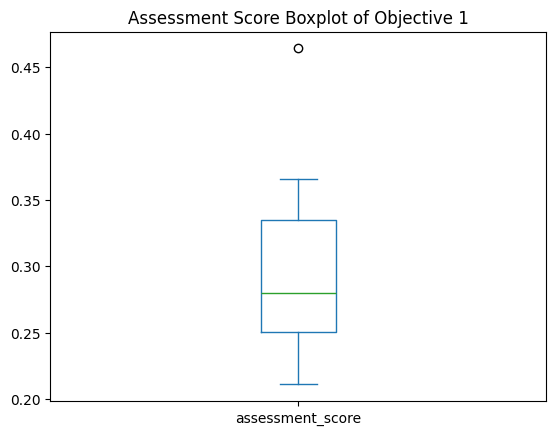

In [31]:
# make boxplot for objective 1 with respect to the assessment score
assessment_score_1 = result_1["assessment_score"].explode().reset_index(drop=True)

if len(assessment_score_1) != 0:
    assessment_score_1.plot(kind="box")
    plt.title("Assessment Score Boxplot of Objective 1")
    plt.show()
else:
    print("No data to show")

# 6. Single Objective Approach: 2) Maximize The Assessment Score

## 6.1. Set The Objective Model

$$
\mu _{Z_2} = max.\: \sum _{i\in \:I_k} \sum _{j\in \:J} \sum _{k\in \:K} \: e_{ij} \cdot z_{ij} \quad \tag{2}
$$


In [32]:
# objective 2
mu_Z_2 = quicksum(
    score[j][i] * z[i, j]
    for k, tasks in company_tasks.items()
    for i in tasks
    for j in employees
)

# single objective 2
model.setObjective(mu_Z_2, GRB.MAXIMIZE)

## 6.2. Solve The Model of Objective $(2)$


In [33]:
# solve the model
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 2 threads

Academic license 2521640 - for non-commercial use only - registered to na___@mail.ugm.ac.id
Optimize a model with 38 rows, 116 columns and 185 nonzeros
Model fingerprint: 0xcc62a9e1
Model has 130 general constraints
Variable types: 0 continuous, 116 integer (115 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [2e-01, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
  GenCon rhs range [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]

Loaded MIP start from previous solve with objective 3.57478

Presolve added 47 rows and 0 columns
Presolve removed 0 rows and 51 columns
Presolve time: 0.00s
Presolved: 85 rows, 65 columns, 295 nonzeros
Found heuristic solution: objective 5.0874096
Variable types:

### 6.2.1 Print The Solver Results


In [34]:
# Check and process the solution
if model.status == GRB.OPTIMAL:
    print("Solution Found!")
    print(f"Obj. Value 2 i.e. Total Score: {model.ObjVal}\n")
    mu_Z_star[2] = model.ObjVal

    x_hat_2 = {}
    for j in employees:
        result = get_employee_tasks(
            j, company_tasks, model, score, story_points, max_employee_workload
        )
        if len(result[1]) > 0:
            x_hat_2[j] = result
else:
    print("No Solution Found!")
    x_hat_2 = {}

Solution Found!
Obj. Value 2 i.e. Total Score: 5.53868543203696

Task T6 assigned to Employee Talent 1
Company			: P1
Story Points		: 1
Metrics score	: 0.1685521227

Task T8 assigned to Employee Talent 1
Company			: P1
Story Points		: 3
Metrics score	: 0.1852891992

Task T10 assigned to Employee Talent 2
Company			: P1
Story Points		: 3
Metrics score	: 0.1666666667

Task T4 assigned to Employee Talent 3
Company			: P3
Story Points		: 5
Metrics score	: 0.3660254038

Task T5 assigned to Employee Talent 3
Company			: P3
Story Points		: 1
Metrics score	: 0.3430703308

Task T7 assigned to Employee Talent 3
Company			: P3
Story Points		: 2
Metrics score	: 0.2466060556

Task T2 assigned to Employee Talent 4
Company			: P1
Story Points		: 2
Metrics score	: 0.3660254038

Task T1 assigned to Employee Talent 5
Company			: P2
Story Points		: 1
Metrics score	: 0.2958163163

Task T3 assigned to Employee Talent 5
Company			: P2
Story Points		: 3
Metrics score	: 0.1639607805

Task T9 assigned to Emplo

## 6.3. Show the Solver's Result


In [35]:
# Set display options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# Convert dictionary to DataFrame and set 'employee' as index
result_2 = pd.DataFrame.from_dict(
    x_hat_2,
    orient="index",
    columns=["company", "assigned_task", "sum_sp", "wasted_sp", "assessment_score"],
)
result_2.index.name = "employee"

result_2

,company,assigned_task,sum_sp,wasted_sp,assessment_score
employee,,,,,
Talent 1,"[P1, P1]","[T6, T8]",4,6,"[0.16855212267069633, 0.1852891992413258]"
Talent 2,[P1],[T10],3,7,[0.16666666666666666]
Talent 3,"[P3, P3, P3]","[T4, T5, T7]",8,2,"[0.36602540378443865, 0.3430703308172536, 0.24..."
Talent 4,[P1],[T2],2,8,[0.36602540378443865]
Talent 5,"[P2, P2, P2]","[T1, T3, T9]",5,5,"[0.2958163163244893, 0.1639607805437114, 0.333..."


### 6.3.1 Statistics of The Objective


In [36]:
total_employee = len(employees)
total_sp = sum(story_points.values())
total_active_employee = len(set(employee for employee in x_hat_2.keys()))
total_active_sp = sum(value[2] for value in x_hat_2.values())
total_idle_employee = total_employee - total_active_employee
total_wasted_sp = total_sp - total_active_sp

print(f"Total Employee\t\t\t: {total_employee}")
print(
    f"Total Active Employee\t\t: {total_active_employee}\t{(total_active_employee/total_employee)*100:.2f}%"
)
print(
    f"Total Idle Employee\t\t: {total_idle_employee}\t{(total_idle_employee/total_employee)*100:.2f}%\n"
)
print(f"Total Story Points\t\t: {total_sp}")
print(
    f"Total Active Story Points\t: {total_active_sp}\t{(total_active_sp/total_sp)*100:.2f}%"
)
print(
    f"Total Wasted Story Points\t: {total_wasted_sp}\t{(total_wasted_sp/total_sp)*100:.2f}%\n"
)

Total Employee			: 5
Total Active Employee		: 5	100.00%
Total Idle Employee		: 0	0.00%

Total Story Points		: 22
Total Active Story Points	: 22	100.00%
Total Wasted Story Points	: 0	0.00%



### 6.3.2. Distribution With Respect to the Assessment Score


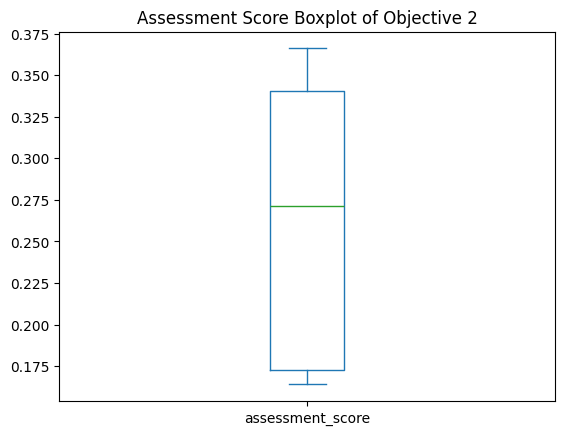

In [37]:
# make boxplot for objective 1 with respect to the assessment score
assessment_score_2 = result_2["assessment_score"].explode().reset_index(drop=True)

if len(assessment_score_2) != 0:
    assessment_score_2.plot(kind="box")
    plt.title("Assessment Score Boxplot of Objective 2")
    plt.show()
else:
    print("No data to show")

# 7. Single Objective Approach: 3) Balancing Workload For Each Employee

## 7.1. Set The Objective Model

$$
\mu_{Z_3} = min.\: \text{max\_workload} \quad \tag{3}
$$


In [38]:
# single objective 3
mu_Z_3 = max_workload
model.setObjective(mu_Z_3, GRB.MINIMIZE)

## 7.2. Solve The Model of Objective $(3)$


In [39]:
# solve the model
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 2 threads

Academic license 2521640 - for non-commercial use only - registered to na___@mail.ugm.ac.id
Optimize a model with 38 rows, 116 columns and 185 nonzeros
Model fingerprint: 0x206164c8
Model has 130 general constraints
Variable types: 0 continuous, 116 integer (115 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
  GenCon rhs range [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]

Loaded MIP start from previous solve with objective 10

Presolve added 47 rows and 0 columns
Presolve removed 0 rows and 50 columns
Presolve time: 0.00s
Presolved: 85 rows, 66 columns, 285 nonzeros
Variable types: 0 continuous, 66 integer (65 binary)
Found heurist

### 7.2.1 Print The Solver Results


In [40]:
# Check and process the solution
if model.status == GRB.OPTIMAL:
    print("Solution Found!")
    print(f"Obj. Value 3 i.e. Maximum Story Points Each Employee: {model.ObjVal}\n")
    mu_Z_star[3] = model.ObjVal

    x_hat_3 = {}
    for j in employees:
        result = get_employee_tasks(
            j, company_tasks, model, score, story_points, max_employee_workload
        )
        if len(result[1]) > 0:
            x_hat_3[j] = result
else:
    print("No Solution Found!")
    x_hat_3 = {}

Solution Found!
Obj. Value 3 i.e. Maximum Story Points Each Employee: 5.0

Task T1 assigned to Employee Talent 1
Company			: P2
Story Points		: 1
Metrics score	: 0.2612038750

Task T3 assigned to Employee Talent 1
Company			: P2
Story Points		: 3
Metrics score	: 0.4641016151

Task T9 assigned to Employee Talent 1
Company			: P2
Story Points		: 1
Metrics score	: 0.2854426166

Task T5 assigned to Employee Talent 2
Company			: P3
Story Points		: 1
Metrics score	: 0.2500000000

Task T7 assigned to Employee Talent 2
Company			: P3
Story Points		: 2
Metrics score	: 0.2055765884

Task T4 assigned to Employee Talent 3
Company			: P3
Story Points		: 5
Metrics score	: 0.3660254038

Task T6 assigned to Employee Talent 4
Company			: P1
Story Points		: 1
Metrics score	: 0.3034973274

Task T10 assigned to Employee Talent 4
Company			: P1
Story Points		: 3
Metrics score	: 0.2108967221

Task T2 assigned to Employee Talent 5
Company			: P1
Story Points		: 2
Metrics score	: 0.2240092377

Task T8 assigne

## 7.3. Show the Solver's Result


In [41]:
# Set display options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# Convert dictionary to DataFrame and set 'employee' as index
result_3 = pd.DataFrame.from_dict(
    x_hat_3,
    orient="index",
    columns=["company", "assigned_task", "sum_sp", "wasted_sp", "assessment_score"],
)
result_3.index.name = "employee"

result_3

,company,assigned_task,sum_sp,wasted_sp,assessment_score
employee,,,,,
Talent 1,"[P2, P2, P2]","[T1, T3, T9]",5,5,"[0.2612038749637414, 0.4641016151377546, 0.285..."
Talent 2,"[P3, P3]","[T5, T7]",3,7,"[0.25, 0.20557658844381702]"
Talent 3,[P3],[T4],5,5,[0.36602540378443865]
Talent 4,"[P1, P1]","[T6, T10]",4,6,"[0.30349732743932833, 0.21089672205953397]"
Talent 5,"[P1, P1]","[T2, T8]",5,5,"[0.2240092377397959, 0.2193450929151803]"


### 7.3.1 Statistics of The Objective


In [42]:
total_employee = len(employees)
total_sp = sum(story_points.values())
total_active_employee = len(set(employee for employee in x_hat_3.keys()))
total_active_sp = sum(value[2] for value in x_hat_3.values())
total_idle_employee = total_employee - total_active_employee
total_wasted_sp = total_sp - total_active_sp

print(f"Total Employee\t\t\t: {total_employee}")
print(
    f"Total Active Employee\t\t: {total_active_employee}\t{(total_active_employee/total_employee)*100:.2f}%"
)
print(
    f"Total Idle Employee\t\t: {total_idle_employee}\t{(total_idle_employee/total_employee)*100:.2f}%\n"
)
print(f"Total Story Points\t\t: {total_sp}")
print(
    f"Total Active Story Points\t: {total_active_sp}\t{(total_active_sp/total_sp)*100:.2f}%"
)
print(
    f"Total Wasted Story Points\t: {total_wasted_sp}\t{(total_wasted_sp/total_sp)*100:.2f}%\n"
)

Total Employee			: 5
Total Active Employee		: 5	100.00%
Total Idle Employee		: 0	0.00%

Total Story Points		: 22
Total Active Story Points	: 22	100.00%
Total Wasted Story Points	: 0	0.00%



### 7.3.2. Distribution With Respect to the Assessment Score


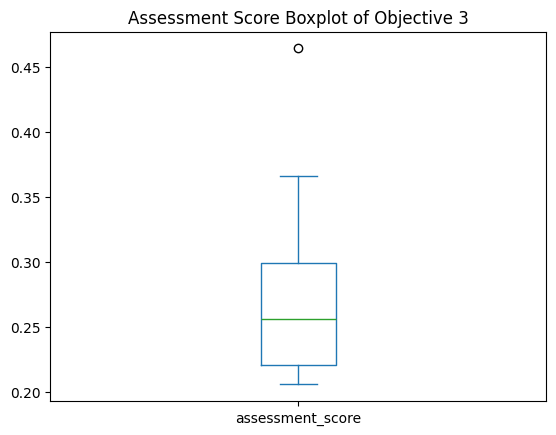

In [43]:
# make boxplot for objective 1 with respect to the assessment score
assessment_score_3 = result_3["assessment_score"].explode().reset_index(drop=True)

if len(assessment_score_3) != 0:
    assessment_score_3.plot(kind="box")
    plt.title("Assessment Score Boxplot of Objective 3")
    plt.show()
else:
    print("No data to show")

# 8. Multi-Objective Approach: 2) Goal Programming Optimization Method

## 8.1. Create Variables for Goal Programming Optimization Method

Let list down the Goals:

- Goal 1 = To minimize the idle employee
- Goal 2 = To maximize the skills score between tasks and employees
- Goal 3 = To balance the workload for each employee

Next, setting up the deviational variables:

$$
\begin{align*}
d^+_1 & : \text{Overachievement of the employee target} \\
d^-_1 & : \text{Underachievement of the employee target} \\
d^+_2 & : \text{Overachievement of the score target} \\
d^-_2 & : \text{Underachievement of the score target} \\
d^+_3 & : \text{Overachievement of the max\_workload target} \\
d^-_3 & : \text{Underachievement of the max\_workload target} \\
\end{align*}
$$

Denote that the deviational variables is non-negative value. Then, setting up Goal Priority as per relevance to the Business and Management:

| Goal                                                        | Priority         |
| ----------------------------------------------------------- | ---------------- |
| 1) To minimize the idle employee                            | $P_3$ with $W_1$ |
| 2) To maximize the skills score between tasks and employees | $P_1$ with $W_2$ |
| 3) To balance the workload for each employee                | $P_2$ with $W_3$ |

We can say that our ideal conditon for each Goal is:

$$
\begin{align*}
goal_1 &= 0 \quad \tag{5} \\
goal_2 &= \text{optimal} \: \sum \text{score} \quad \tag{6} \\
goal_3 &\leq \text{max\_workload} \quad \tag{7}
\end{align*}
$$

Let's consider Underachievement of the $goal_1$ doesn't give any impact because the minimum value of deviation varable is 0, and 0 is our ideal condition. Then, consider Overachievement of the $goal_3$ doesn't give any impact because the maximum value is $\text{max\_workload}$, so the value that greater than $\text{max\_workload}$ can be ignored.

Hence, $d^-_1$ and $d^+_3$ can be omitted from the objective function. So for the final formation of Objective Function and Constraint is:

$$
\mu_{Z_4} = \text{min.} \: \sum_{n=1}^3\left[\frac{W_n \cdot \left(d_n^+ + d_n^-\right)}{\mu_{Z_n^{\ast}}}\right] \quad \tag{8}
$$

subject to:

$$
\mu Z_n-d^+_n+d^-_n=\mu Z_n^{\ast }\quad \forall \:n\in Goal \quad \tag{9}
$$


### 8.1.1 Weight for Priority


In [44]:
# define weight dictionary for each objective
Weight = {
    1: weight_obj1,
    2: weight_obj2,
    3: weight_obj3,
}

### 8.1.2 Deviation Variables


In [45]:
# Define the deviation plus and minus variables
d_plus = {}
d_minus = {}

# Add variables for d_plus and d_minus with specific conditions
for i in range(1, 4):
    if i != 3:
        d_plus[i] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"d_plus_{i}")
    if i != 1:
        d_minus[i] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"d_minus_{i}")

# Set specific variables to zero
d_minus[1] = 0
d_plus[3] = 0

### 8.1.3 Get the Objectives and Goal for Each Objetives


In [46]:
mu_Z = {1: mu_Z_1, 2: mu_Z_2, 3: mu_Z_3}

mu_Z_star_obj = mu_Z_star.copy()
for i, value in mu_Z_star_obj.items():
    print(value)
    mu_Z_star_obj[i] = 1 / value if value != 0 else 0

mu_Z_star_obj

0.0
5.53868543203696
5.0


{1: 0, 2: 0.18054825685094567, 3: 0.2}

## 8.2 Set Additional Constraint $(9)$ for Multi-Objective


In [47]:
# This constraint is bound for each objective can connected with each other
for k, w in Weight.items():
    if w != 0:
        print(f"Constraint for Goal {k} Active.")
        model.addConstr(mu_Z[k] - d_plus[k] + d_minus[k] == mu_Z_star[k])

Constraint for Goal 1 Active.
Constraint for Goal 2 Active.
Constraint for Goal 3 Active.


## 8.3 Set The Objective Model


In [48]:
# define D = sum k=1 to 3 ((W_plus_k * d_plus_k) + (W_minus_k * d_minus_k)) / mu_Z_star iterate
D = quicksum(
    ((Weight[i] * (d_plus[i] + d_minus[i])) * mu_Z_star_obj[i] for i in range(1, 4))
)

In [49]:
# Minimize D
model.setObjective(D, GRB.MINIMIZE)

## 8.4 Solve The Model of Objective $(8)$


In [50]:
gap_callback = GapCallback()
model.setParam("MIPGap", MIPGap_moo)

# Solve the model
model.optimize(gap_callback)

Set parameter MIPGap to value 0.05
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 2 threads

Academic license 2521640 - for non-commercial use only - registered to na___@mail.ugm.ac.id
Optimize a model with 41 rows, 120 columns and 255 nonzeros
Model fingerprint: 0x23b10193
Model has 130 general constraints
Variable types: 4 continuous, 116 integer (115 binary)
Coefficient statistics:
  Matrix range     [2e-01, 5e+00]
  Objective range  [1e-02, 2e-01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
  GenCon rhs range [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 0.384913 (0.01s)
Loaded MIP start from previous solve with objective 0.384913

Presolve added 85 rows and 0 columns
Presolve removed 0 rows and 18 columns
Presolve ti

### 8.2.1 Print The Solver Results


In [51]:
if model.status == GRB.OPTIMAL:
    print(d_plus[1].X, d_plus[2].X, d_plus[3])
    print(d_minus[1], d_minus[2].X, d_minus[3].X)

0.0 0.0 0
0 1.0177766613026233 0.0


In [52]:
for i in range(1, 4):
    print(f"Objective {i}: {mu_Z[i]}")

Objective 1: 5.0 + -1.0 y_Talent 1_P1 + -1.0 y_Talent 1_P2 + -1.0 y_Talent 1_P3 + -1.0 y_Talent 2_P1 + -1.0 y_Talent 2_P2 + -1.0 y_Talent 2_P3 + -1.0 y_Talent 3_P1 + -1.0 y_Talent 3_P2 + -1.0 y_Talent 3_P3 + -1.0 y_Talent 4_P1 + -1.0 y_Talent 4_P2 + -1.0 y_Talent 4_P3 + -1.0 y_Talent 5_P1 + -1.0 y_Talent 5_P2 + -1.0 y_Talent 5_P3
Objective 2: 0.18933139574356017 z_T2_Talent 1 + 0.3090169943749474 z_T2_Talent 2 + 0.25 z_T2_Talent 3 + 0.36602540378443865 z_T2_Talent 4 + 0.2240092377397959 z_T2_Talent 5 + 0.16855212267069633 z_T6_Talent 1 + 0.21498516621900873 z_T6_Talent 2 + 0.24727258247841533 z_T6_Talent 3 + 0.30349732743932833 z_T6_Talent 4 + 0.27429188517743175 z_T6_Talent 5 + 0.1852891992413258 z_T8_Talent 1 + 0.2958163163244893 z_T8_Talent 2 + 0.25805245234583163 z_T8_Talent 3 + 0.3797958971132712 z_T8_Talent 4 + 0.2193450929151803 z_T8_Talent 5 + z_T10_Talent 1 + 0.16666666666666666 z_T10_Talent 2 + 0.28989794855663564 z_T10_Talent 3 + 0.21089672205953397 z_T10_Talent 4 + 0.156613

In [53]:
# print the result
if model.status == GRB.OPTIMAL:
    print("Solution Found!")
    print(f"Obj. Value of MOO i.e. Deviation: {model.ObjVal}\n")

    x_hat_4 = {}
    for j in employees:
        result = get_employee_tasks(
            j, company_tasks, model, score, story_points, max_employee_workload
        )
        if len(result[1]) > 0:
            x_hat_4[j] = result
else:
    print("No Solution Found!")
    x_hat_4 = {}

Solution Found!
Obj. Value of MOO i.e. Deviation: 0.1653820218555876

Task T6 assigned to Employee Talent 1
Company			: P1
Story Points		: 1
Metrics score	: 0.1685521227

Task T10 assigned to Employee Talent 1
Company			: P1
Story Points		: 3
Metrics score	: 1.0000000000

Task T1 assigned to Employee Talent 2
Company			: P2
Story Points		: 1
Metrics score	: 0.3797958971

Task T3 assigned to Employee Talent 2
Company			: P2
Story Points		: 3
Metrics score	: 0.1597466730

Task T9 assigned to Employee Talent 2
Company			: P2
Story Points		: 1
Metrics score	: 0.3538893679

Task T5 assigned to Employee Talent 3
Company			: P3
Story Points		: 1
Metrics score	: 0.3430703308

Task T7 assigned to Employee Talent 3
Company			: P3
Story Points		: 2
Metrics score	: 0.2466060556

Task T2 assigned to Employee Talent 4
Company			: P1
Story Points		: 2
Metrics score	: 0.3660254038

Task T8 assigned to Employee Talent 4
Company			: P1
Story Points		: 3
Metrics score	: 0.3797958971

Task T4 assigned to 

## 8.5 Show the Solver's Result


In [54]:
# Set display options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# show data that has positive metrics score

result_4 = pd.DataFrame.from_dict(
    x_hat_4,
    orient="index",
    columns=["company", "assigned_task", "sum_sp", "wasted_sp", "assessment_score"],
)

result_4.index.name = "employee"
result_4

,company,assigned_task,sum_sp,wasted_sp,assessment_score
employee,,,,,
Talent 1,"[P1, P1]","[T6, T10]",4,6,"[0.16855212267069633, 1.0]"
Talent 2,"[P2, P2, P2]","[T1, T3, T9]",5,5,"[0.3797958971132712, 0.15974667297574377, 0.35..."
Talent 3,"[P3, P3]","[T5, T7]",3,7,"[0.3430703308172536, 0.24660605559646726]"
Talent 4,"[P1, P1]","[T2, T8]",5,5,"[0.36602540378443865, 0.3797958971132712]"
Talent 5,[P3],[T4],5,5,[0.23441237831492112]


### 8.5.1 Statistics of The Objective


In [55]:
total_employee = len(employees)
total_sp = sum(story_points.values())
total_active_employee = len(set(employee for employee in x_hat_4.keys()))
total_active_sp = sum(value[2] for value in x_hat_4.values())
total_idle_employee = total_employee - total_active_employee
total_wasted_sp = total_sp - total_active_sp

print(f"Total Employee\t\t\t: {total_employee}")
print(
    f"Total Active Employee\t\t: {total_active_employee}\t{(total_active_employee/total_employee)*100:.2f}%"
)
print(
    f"Total Idle Employee\t\t: {total_idle_employee}\t{(total_idle_employee/total_employee)*100:.2f}%\n"
)
print(f"Total Story Points\t\t: {total_sp}")
print(
    f"Total Active Story Points\t: {total_active_sp}\t{(total_active_sp/total_sp)*100:.2f}%"
)
print(
    f"Total Wasted Story Points\t: {total_wasted_sp}\t{(total_wasted_sp/total_sp)*100:.2f}%\n"
)

Total Employee			: 5
Total Active Employee		: 5	100.00%
Total Idle Employee		: 0	0.00%

Total Story Points		: 22
Total Active Story Points	: 22	100.00%
Total Wasted Story Points	: 0	0.00%



### 8.5.2. Distribution With Respect to the Assessment Score


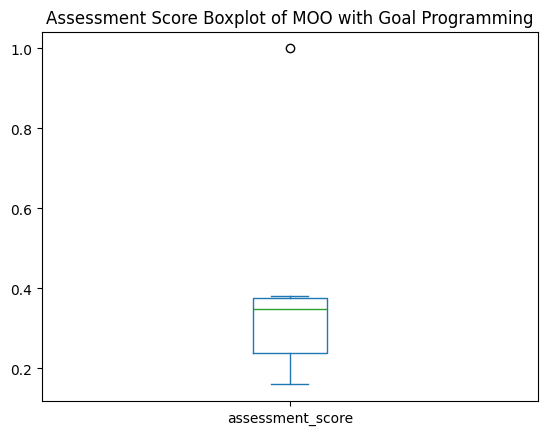

In [56]:
# make boxplot for x_hat_5
assessment_score_4 = result_4["assessment_score"].explode().reset_index(drop=True)

if len(assessment_score_4) != 0:
    assessment_score_4.plot(kind="box")
    plt.title("Assessment Score Boxplot of MOO with Goal Programming")
    plt.show()
else:
    print("No data to show")

## 8.6 Comparing MOO with Goal Programming to Single Objective


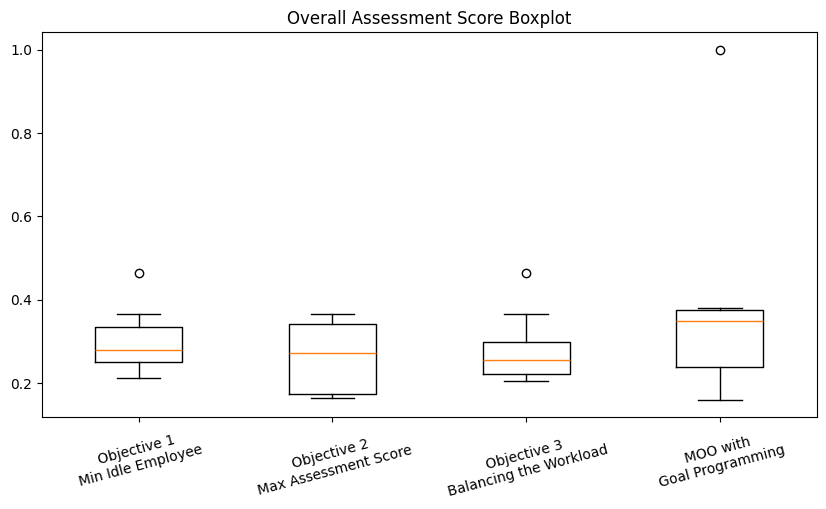

In [57]:
# Merge all boxplot in one graph
data = [
	assessment_score_1,
	assessment_score_2,
	assessment_score_3,
	assessment_score_4,
]

plt.figure(figsize=(10, 5))
plt.boxplot(
	data,
	tick_labels=[
		"Objective 1\nMin Idle Employee",
		"Objective 2\nMax Assessment Score",
		"Objective 3\nBalancing the Workload",
		"MOO with\nGoal Programming",
	],
)
plt.title("Overall Assessment Score Boxplot")
plt.xticks(rotation=15)
plt.savefig("./output/compare_SO_MOO.png")
plt.show()